# DATA PROJECT
## - *A description of the Danish labour market under COVID-19*
COVID-19 hit Denmark at the 13 of march 2020 where the country went into a full-scale lockdown. This of course hit the labour-market.
COVID-19 hits different sectors, age and gender in different force.

This notebook seeks to describe the effects of COVID-19 on the labour market.




**Import packages**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import ipywidgets as widgets
plt.style.use('seaborn-whitegrid')


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import dataproject

# Read and clean data

**Import package Pydst to get data using an API from Statistics Denmark**

In [2]:
#pip install git+https://github.com/elben10/pydst 
#to run this the above code needs to be installed in terminal
import pydst
Dst = pydst.Dst(lang='en')
Dst.get_subjects()

,id,desc,active,hasSubjects
0,02,Population and elections,True,True
1,04,"Labour, income and wealth",True,True
2,06,Prices and consumption,True,True
3,05,Living conditions,True,True
4,14,National accounts and government finances,True,True
5,03,Education and knowledge,True,True
6,11,Business sectors,True,True
7,07,Business sector in general,True,True
8,16,Money and credit market,True,True
9,13,External economy,True,True


In [3]:
# We're interested in the labour marking which is a part the subject 'Labour, income and wealth' with id=04
tables = Dst.get_tables(subjects=['04'])
tables

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
0,AKU100K,Seasonally adjusted labour force status,"1,000 people",2021-02-17 08:00:00,2008Q1,2020Q4,True,"[employment status, time]"
1,AKU101K,Seasonally adjusted labour force status in per...,per cent,2021-02-17 08:00:00,2008Q1,2020Q4,True,"[employment status, time]"
2,AKU110K,Labour force status,"1,000 people",2021-02-17 08:00:00,2008Q1,2020Q4,True,"[employment status, age, sex, time]"
3,AKU111K,Labour force status in percentage,per cent,2021-02-17 08:00:00,2008Q1,2020Q4,True,"[employment status, age, sex, time]"
4,AKU120K,Labour force status,"1,000 people",2021-02-17 08:00:00,2008Q1,2020Q4,True,"[employment status, region, time]"
...,...,...,...,...,...,...,...,...
239,TJEN01,Accrued civil servant pension for active civil...,-,2020-12-10 08:00:00,2014,2019,True,"[sector, unit, sex, profession, ages groups, t..."
240,TJEN02,Accrued civil servant pension for retired civi...,-,2020-12-10 08:00:00,2014,2019,True,"[sector, unit, sex, time]"
241,PENSOC,Supplementary table for accrued-to-date pensio...,m DKK,2020-12-23 08:00:00,2015,2019,True,"[pension schemes, account, time]"
242,PENS6,Value of pension schemes (except special schem...,-,2020-09-15 08:00:00,2015,2019,True,"[kind of pension, company type, unit, family t..."


## Getting data from table: AUS07
In the subject 'Labour, income and wealth' we're interested in employment and unemployment
We would like to describe the effect of COVID-19 on employment and unemployment.
Therefore we would need a datasource which published more frequently than a yearly basis
the table AUS07 is published monthly and contains gross unemployment (both seasonally adjusted and actual) by sex and age
gross unemployment covers non-activated unemployed (net unemployment) and activated unemployed

In [4]:
# Storing table AUS07
data_aus07 = tables[tables.id=='AUS07']
# Getting an overview of the different variables in AUS07
aus_vars = Dst.get_variables(table_id='AUS07')
aus_vars

,id,text,elimination,time,values
0,YD,"benefits, sex and age",False,False,"[{'id': 'TOT', 'text': 'Gross unemployment'}, ..."
1,SAESONFAK,seasonal adjustment and actual figures,False,False,"[{'id': '9', 'text': 'Seasonally adjusted figu..."
2,Tid,time,False,True,"[{'id': '2007M01', 'text': '2007M01'}, {'id': ..."


In [5]:
# Printing the values for each variable, i.e. getting an overview of AUS07
for id in ['YD', 'SAESONFAK','Tid']:
    print(id)
    values = aus_vars.loc[aus_vars.id == id, ['values']].values[0,0]
    for value in values:
        print(f' id = {value["id"]}, text = {value["text"]}')

YD
 id = TOT, text = Gross unemployment
 id = NET, text = Net unemployment
 id = LDP, text = Net unemployed recipients of unemployment benefits
 id = LKT, text = Net unemployed recipients of social assistance
 id = AKI, text = Activation total
 id = ADP, text = Activation of persons on unemployment benefits
 id = AKT, text = Activation of persons on social assistance (prepared for employment)
 id = MEN, text = Men
 id = KVR, text = Women
 id = U25, text = 16-24 years
 id = O25, text = 25-29 years
 id = O30, text = 30-39 years
 id = O40, text = 40-49 years
 id = O50, text = 50-59 years
 id = O60, text = 60 years and more
SAESONFAK
 id = 9, text = Seasonally adjusted figures in percent of the labour force
 id = 10, text = Seasonally adjusted
 id = 22, text = Enumerated actual figures  in percent of the labour force
 id = 24, text = Enumerated actual figures
Tid
 id = 2007M01, text = 2007M01
 id = 2007M02, text = 2007M02
 id = 2007M03, text = 2007M03
 id = 2007M04, text = 2007M04
 id = 20

In [30]:
#### do we need this part?
variables = {'YD': ['TOT','MEN', 'KVR', 'U25', 'O25', 'O30', 'O40', 'O50', 'O60'], 'SAESONFAK': ['10'],'Tid': ['*']}
aus07 = Dst.get_data(table_id = 'AUS07', variables = variables)
aus07 = aus07.drop(['SAESONFAK'], axis=1)

aus07['TID'] = aus07['TID'].str.replace(r'\D', '')
aus07['TID'] =  pd.to_datetime(aus07['TID'],
                              format='%Y%m')

C:\Users\olufk\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


## Getting full-time unemployed as share of workforce (gross unemployed + gross employed) by gender and age.
AUP02 contains such data on a monthly basis, however this data is actual data, i.e. not seasonally adjusted.


In [9]:
# Listing variables of AUP02
aup02_vars = Dst.get_variables(table_id='AUP02')
aup02_vars

,id,text,elimination,time,map,values
0,OMRÅDE,region,True,False,denmark_municipality_07,"[{'id': '000', 'text': 'All Denmark'}, {'id': ..."
1,ALDER,age,True,False,NaN,"[{'id': 'TOT', 'text': 'Age, total'}, {'id': '..."
2,KØN,sex,True,False,NaN,"[{'id': 'TOT', 'text': 'Total'}, {'id': 'M', '..."
3,Tid,time,False,True,NaN,"[{'id': '2007M01', 'text': '2007M01'}, {'id': ..."


In [10]:
# Listing values of variables in AUP02
for id in ['ALDER', 'KØN','Tid']:
    print(id)
    values = aup02_vars.loc[aup02_vars.id == id, ['values']].values[0,0]
    for value in values:
        print(f' id = {value["id"]}, text = {value["text"]}')

ALDER
 id = TOT, text = Age, total
 id = 16-24, text = 16-24 years
 id = 25-29, text = 25-29 years
 id = 30-39, text = 30-39 years
 id = 40-49, text = 40-49 years
 id = 50-59, text = 50-59 years
 id = 6099, text = 60 year and over
KØN
 id = TOT, text = Total
 id = M, text = Men
 id = K, text = Women
Tid
 id = 2007M01, text = 2007M01
 id = 2007M02, text = 2007M02
 id = 2007M03, text = 2007M03
 id = 2007M04, text = 2007M04
 id = 2007M05, text = 2007M05
 id = 2007M06, text = 2007M06
 id = 2007M07, text = 2007M07
 id = 2007M08, text = 2007M08
 id = 2007M09, text = 2007M09
 id = 2007M10, text = 2007M10
 id = 2007M11, text = 2007M11
 id = 2007M12, text = 2007M12
 id = 2008M01, text = 2008M01
 id = 2008M02, text = 2008M02
 id = 2008M03, text = 2008M03
 id = 2008M04, text = 2008M04
 id = 2008M05, text = 2008M05
 id = 2008M06, text = 2008M06
 id = 2008M07, text = 2008M07
 id = 2008M08, text = 2008M08
 id = 2008M09, text = 2008M09
 id = 2008M10, text = 2008M10
 id = 2008M11, text = 2008M11
 id =

In [29]:
variables = {'ALDER': ['*'], 'KØN': ['*'],'Tid': ['*']}
aup02 = Dst.get_data(table_id = 'AUP02', variables = variables)
aup02 = aup02.drop(['OMRÅDE'], axis=1)

aup02['TID'] = aup02['TID'].str.replace(r'\D', '')
aup02['TID'] =  pd.to_datetime(aup02['TID'],
                              format='%Y%m')

C:\Users\olufk\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


## Getting data from table: LBESK03
### Contains data on employment on a monthly basis (seasonally adjusted) by industry.

In [12]:
# Listing variables of LBESK03
data_lbesk03 = tables[tables.id=='LBESK03']
data_lbesk03
lbesk_vars = Dst.get_variables(table_id='LBESK03')
lbesk_vars

,id,text,elimination,time,values
0,BRANCHEDB071038,industry (DB07 10- and 19-grouping),True,False,"[{'id': 'TOT', 'text': 'TOT Industry, total'},..."
1,Tid,time,False,True,"[{'id': '2008M01', 'text': '2008M01'}, {'id': ..."


In [13]:
# Listing value of variables in LBESK03
for id in ['BRANCHEDB071038','Tid']:
    print(id)
    values = lbesk_vars.loc[lbesk_vars.id == id, ['values']].values[0,0]
    for value in values:
        print(f' id = {value["id"]}, text = {value["text"]}')


BRANCHEDB071038
 id = TOT, text = TOT Industry, total
 id = 1, text = 1 Agriculture, forestry and fishing
 id = A, text = A Agriculture, forestry and fishing
 id = 2, text = 2 Manufacturing, mining and quarrying, and utility services
 id = B, text = B Mining and quarrying
 id = C, text = C Manufacturing
 id = D, text = D Electricity, gas, steam and air conditioning supply
 id = E, text = E Water supply, sewerage and waste management
 id = 3, text = 3 Construction
 id = F, text = F Construction
 id = 4, text = 4 Trade and transport etc.
 id = G, text = G Wholesale and retail trade
 id = H, text = H Transportation
 id = I, text = I Accommodation and food service activities
 id = 5, text = 5 Information and communication
 id = J, text = J Information and communication
 id = 6, text = 6 Financial and insurance
 id = K, text = K Financial and insurance
 id = 7, text = 7 Real estate
 id = L, text = L Real estate activities
 id = 8, text = 8 Other business services
 id = M, text = M Knowledge

In [14]:
# Storing relevant data
variables = {'BRANCHEDB071038': ['TOT', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'X'],'Tid': ['*']}
lbesk03 = Dst.get_data(table_id = 'LBESK03', variables = variables)
lbesk03.rename(columns = {'BRANCHEDB071038': 'industry'}, inplace = True)

lbesk03['TID'] = lbesk03['TID'].str.replace(r'\D', '')
lbesk03['TID'] =  pd.to_datetime(lbesk03['TID'],
                              format='%Y%m')

lbesk03 = lbesk03.sort_values('TID')

lbesk03.head(100)

C:\Users\olufk\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


,industry,TID,INDHOLD
2917,"O Public administration, defence and compulsor...",2008-01-01,143628
2923,X Activity not stated,2008-01-01,1425
2922,"TOT Industry, total",2008-01-01,2716275
2921,S Other service activities etc.,2008-01-01,61016
2920,"R Arts, entertainment and recreation activities",2008-01-01,45329
...,...,...,...
2996,J Information and communication,2008-05-01,98294
2995,I Accommodation and food service activities,2008-05-01,82090
2994,H Transportation,2008-05-01,150453
2993,G Wholesale and retail trade,2008-05-01,434065


## Getting data from table: LSK01
### LSK01 is a table containing vacancies in different industries, based on a questionaire

In [15]:
# Listing variable in LSK01
data_lsk01 = tables[tables.id=='LSK01']
lsk_vars = Dst.get_variables(table_id='LSK01')
lsk_vars

,id,text,elimination,time,values
0,BRANCHE,industry,True,False,"[{'id': '0', 'text': 'Total'}, {'id': '2', 'te..."
1,ENHED,unit,False,False,"[{'id': 'LS', 'text': 'Job vacancies (number)'..."
2,STØRRELSE,size,True,False,"[{'id': '000', 'text': 'Workplaces total'}, {'..."
3,Tid,time,False,True,"[{'id': '2010K1', 'text': '2010Q1'}, {'id': '2..."


In [16]:
# Listing values in variables of LSK01
for id in ['BRANCHE','ENHED', 'Tid']:
    print(id)
    values = lsk_vars.loc[lsk_vars.id == id, ['values']].values[0,0]
    for value in values:
        print(f' id = {value["id"]}, text = {value["text"]}')

BRANCHE
 id = 0, text = Total
 id = 2, text = 2 Manufacturing, mining and quarrying, and utility services
 id = 3, text = 3 Construction
 id = 4, text = 4 Trade and transport etc.
 id = 5, text = 5 Information and communication
 id = 6-7, text = 6-7 Financial, insurance and real estate
 id = 8, text = 8 Other business services
ENHED
 id = LS, text = Job vacancies (number)
 id = ALS, text = Job vacancy rate (per cent)
Tid
 id = 2010K1, text = 2010Q1
 id = 2010K2, text = 2010Q2
 id = 2010K3, text = 2010Q3
 id = 2010K4, text = 2010Q4
 id = 2011K1, text = 2011Q1
 id = 2011K2, text = 2011Q2
 id = 2011K3, text = 2011Q3
 id = 2011K4, text = 2011Q4
 id = 2012K1, text = 2012Q1
 id = 2012K2, text = 2012Q2
 id = 2012K3, text = 2012Q3
 id = 2012K4, text = 2012Q4
 id = 2013K1, text = 2013Q1
 id = 2013K2, text = 2013Q2
 id = 2013K3, text = 2013Q3
 id = 2013K4, text = 2013Q4
 id = 2014K1, text = 2014Q1
 id = 2014K2, text = 2014Q2
 id = 2014K3, text = 2014Q3
 id = 2014K4, text = 2014Q4
 id = 2015K1, t

In [17]:
# Storing data with relevant Industries
variables = {'BRANCHE': ['0','2', '3', '4', '5', '6-7', '8'], 'Enhed': ['LS'], 'Tid': ['*']}
lsk01 = Dst.get_data(table_id = 'LSK01', variables = variables)
lsk01.head()

,BRANCHE,ENHED,TID,STØRRELSE,INDHOLD
0,Total,Job vacancies (number),2010Q1,Workplaces total,19094.0
1,"2 Manufacturing, mining and quarrying, and uti...",Job vacancies (number),2010Q1,Workplaces total,2854.0
2,3 Construction,Job vacancies (number),2010Q1,Workplaces total,1362.0
3,4 Trade and transport etc.,Job vacancies (number),2010Q1,Workplaces total,7857.0
4,5 Information and communication,Job vacancies (number),2010Q1,Workplaces total,1666.0


In [19]:
lsk01.rename(columns = {'INDHOLD': 'jobvacancies', 'TID': 'TIME', 'BRANCHE': 'industry'}, inplace = True)
lsk01 = lsk01.drop(['ENHED', 'STØRRELSE'], axis=1)
# Formatting to datetime
lsk01['TIME'] =  pd.to_datetime(lsk01['TIME'])
# Data is reported end of quarter and therefore formatted as such
lsk01['TIME'] = lsk01['TIME'] + pd.offsets.QuarterEnd(0)
lsk01.head(100)

,industry,TIME,jobvacancies
0,Total,2010-03-31,19094.0
1,"2 Manufacturing, mining and quarrying, and uti...",2010-03-31,2854.0
2,3 Construction,2010-03-31,1362.0
3,4 Trade and transport etc.,2010-03-31,7857.0
4,5 Information and communication,2010-03-31,1666.0
...,...,...,...
95,5 Information and communication,2013-06-30,2469.0
96,"6-7 Financial, insurance and real estate",2013-06-30,1306.0
97,8 Other business services,2013-06-30,5581.0
98,Total,2013-09-30,21175.0


# Merge data sets

In [20]:
dstmerge = pd.merge(aus07, lbesk03, how='outer', on=['TID']);
dstmerge.rename(columns = {'INDHOLD_x': 'Unemployed', 'INDHOLD_y': 'Employed', 'TID': 'TIME'}, inplace = True)
# Removing pre 2008 as there are empty cells
dstmerge = dstmerge.dropna(axis=0)
dstmerge = dstmerge.sort_values('TIME')

dstmerge.head()

,YD,TIME,Unemployed,industry,Employed
1160,60 years and more,2008-01-01,3055.5,J Information and communication,98249.0
1093,30-39 years,2008-01-01,22716.2,"D Electricity, gas, steam and air conditioning...",11773.0
1094,30-39 years,2008-01-01,22716.2,C Manufacturing,375631.0
1095,30-39 years,2008-01-01,22716.2,B Mining and quarrying,4616.0
1096,30-39 years,2008-01-01,22716.2,"A Agriculture, forestry and fishing",39553.0


# Data Analysis

In this project we have used data from Statistics Denmark. We have collected data by using their API, where we have extracted data on the gross unemployment and the employment since 2008, by the tables: AUS07, LBESK01. Furthermore, we have collected data regarding job vacancies from the table LSK01.

The gross unemployment are defined as the number of net unemployed and persons in activation. The employment data is based on the total number of employees per month and the number of employed in 20 branches. The data are seasonally adjusted and computed monthly data.

The data on job vacancies is based on the number of job vacanies on 6 branches since 2010, and computed quarterly.

<function matplotlib.pyplot.show(close=None, block=None)>

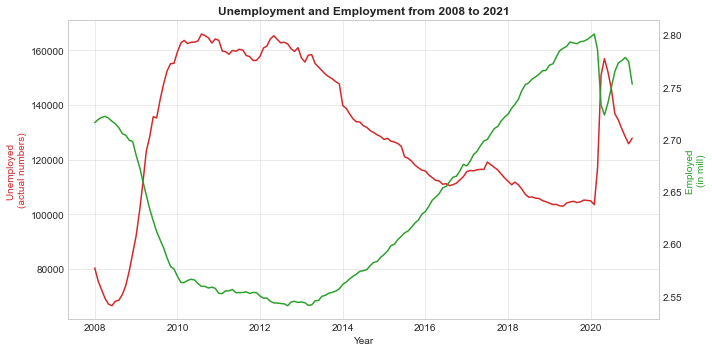

In [21]:
#Unemployment and employment from 2008 to 2021
#Data, unemployment and employment (using the subset of employment total from all industries):
x = dstmerge.TIME.unique()
z = lbesk03.TID.unique()
data1 = dstmerge[(dstmerge['YD']=='Gross unemployment') & (dstmerge['industry']=='TOT Industry, total')]['Unemployed']
data2 = lbesk03[lbesk03['industry']=='TOT Industry, total']['INDHOLD']/1000000


#Create figure
fig, ax1 = plt.subplots(figsize = (10,5))
plt.title(f'Unemployment and Employment from 2008 to 2021', fontweight = 'bold')
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Unemployed \n(actual numbers)', color=color)
ax1.plot(x, data1, label=f'Unemployed', color = color)

#Second axis:
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Employed \n(in mill)', color = color)
ax2.plot(z,data2, label = f'Employed', color = color)
ax2.ticklabel_format(useOffset=False, style='plain', axis='y')

ax1.grid(alpha = 0.5)
ax2.grid(None)

#To avoid the right y-label is clipped:
fig.tight_layout()

plt.show

Figure 1 illustrated that when the Financial Crisis hit in 2008 the gross unemployment rose from 68,223 in July 2008 to the peak at 165,994.2 in August of 2010, which is an 143 percent increase in unemployment in the given period. From August 2010 to May 2012 the number of unemployed is stabilized around 165,000.0 unemployed. The unemployment has from May 2012 to September 2017 continued to fall to the level around 110.000 unemployed, until the effect of lock-down due to COVID-19 hits the employment numbers in February 2020. In March 2020 the unemployment increases rapidly to 156,973.3 in May 2020, which is a 52.4 percent increase in unemployment. An increase in employment on 150.000 appears from May to December 2020 approximately, which might be due to the Danish Governments fiscal policy and the fact the many lock-down restrictions was dropped from August to December 2020. Furthermore, there is an inverse relationship between the development in unemployed and employed, but is not 1-1 due to a worker can drop out of or enter the labor force.

## Unemployment

### Unemployment on gender

In [24]:
#unemployed - gender
def plot_gender(aus07, gender):
    df = aus07[(aus07['YD'] == 'Gross unemployment') | (aus07['YD'] == 'Women') | (aus07['YD'] == 'Men')]
    
    I = df['YD'] == gender
#     temp = df.copy()
    temp = df.loc[I,:]
    temp = temp.sort_values('TID')
    
    # Storing relevant variables
    x = temp['TID']
    y1 = temp['INDHOLD']
    temp = df.loc[df['YD']=='Gross unemployment',['TID', 'INDHOLD']].sort_values('TID')
    y2 = temp['INDHOLD'] 
    
     # modifying plot
    fig, ax1 = plt.subplots(figsize = (10,5))
    plt.title(f'Danish uemployment by gender', fontweight = 'bold')
    color1 = 'tab:red'
    color2 = 'tab:blue'
    # First axis
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Unemployed by gender', color = color1)
    ax1.plot(x,y1, label = f'Unemployed', color = color1)
    
    # Second axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Gross Unemployment', color = color2)
    ax2.plot(x,y2, color = color2, label='Gross Unemployment')
    ax2.ticklabel_format(useOffset=False, style='plain', axis='y')
    
    # remove second axis gridlines
    plt.grid(None) 
    ax1.grid(alpha = 0.5)
    


# creating options for the interactive figure
opt = aus07[(aus07['YD'] == 'Gross unemployment') | (aus07['YD'] == 'Women') | (aus07['YD'] == 'Men')].YD.unique()
# Excluding Gross unemployment as its already on the second axis
opt = np.delete(opt, np.where(opt == 'Gross unemployment'))
    
    
widgets.interact(plot_gender,
    aus07 = widgets.fixed(aus07),
    gender = widgets.Dropdown(description='Gender', 
                                options=opt,
                                value='Women')
);

interactive(children=(Dropdown(description='Gender', index=1, options=('Men', 'Women'), value='Women'), Output…

### Unemployment on age

In [25]:
#unemployed - age
def plot_age(aus07, age):
    df = aus07[(aus07['YD'] == 'Gross unemployment') | 
           (aus07['YD'] == '16-24 years') |
           (aus07['YD'] == '25-29 years')|
           (aus07['YD'] == '30-39 years')|
           (aus07['YD'] == '40-49 years')|
           (aus07['YD'] == '50-59 years')|
           (aus07['YD'] == '60 years and more')
          ]
    I = df['YD'] == age
    temp = df.loc[I,:]
    temp = temp.sort_values('TID')
    # storing relevant values
    x = temp['TID']
    y1 = temp['INDHOLD']
    temp = df.loc[df['YD']=='Gross unemployment', ['INDHOLD', 'TID']].sort_values('TID')
    y2 = temp['INDHOLD']    
    
    # modifying plot
    fig, ax1 = plt.subplots(figsize = (10,5))
    plt.title(f'Danish uemployment by age', fontweight = 'bold')
    color1 = 'tab:red'
    color2 = 'tab:blue'
    # First axis
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Unemployed by age', color = color1)
    ax1.plot(x,y1, label = f'Unemployed', color = color1)
    
    # Second axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Gross Unemployment', color = color2)
    ax2.plot(x,y2, color = color2, label='Gross Unemployment')
    ax2.ticklabel_format(useOffset=False, style='plain', axis='y')
    
    # remove second axis gridlines
    plt.grid(None) 
    ax1.grid(alpha = 0.5)

    

# creating options for the interactive figure
opt = aus07[(aus07['YD'] == 'Gross unemployment') | 
           (aus07['YD'] == '16-24 years') |
           (aus07['YD'] == '25-29 years')|
           (aus07['YD'] == '30-39 years')|
           (aus07['YD'] == '40-49 years')|
           (aus07['YD'] == '50-59 years')|
           (aus07['YD'] == '60 years and more')
          ].YD.unique()
# Excluding Gross unemployment as its already on the second axis
opt = np.delete(opt, np.where(opt == 'Gross unemployment'))

widgets.interact(plot_age,
    aus07 = widgets.fixed(aus07),
    age = widgets.Dropdown(description='Age', 
                                options=opt,
                                value='16-24 years')
);

interactive(children=(Dropdown(description='Age', options=('16-24 years', '25-29 years', '30-39 years', '40-49…

In [26]:
#unemployed - age
def plot_age(aup02, age):
    I = aup02['KØN'] == 'Total'
    temp_df = aup02.loc[I,:]
    I = temp_df['ALDER'] == age
    temp = temp_df.loc[I,:]
    temp = temp.sort_values('TID')
    # storing relevant values
    x = temp['TID']
    y1 = temp['INDHOLD']
    # Creating a 13 month centered moving average
    y12 = temp.loc[:,['INDHOLD']].rolling(window = 13, center = True).mean()
    temp_df = temp_df.loc[temp_df['ALDER']=='Age, total', ['INDHOLD', 'TID']].sort_values('TID')
    y2 = temp_df['INDHOLD']    
    # Creating a 13 month centered moving average
    y22 = temp_df.loc[:,['INDHOLD']].rolling(window = 13, center = True).mean()
    
    # modifying plot
    fig, ax1 = plt.subplots(figsize = (12,6))
    plt.title(f'Full-time uemployed as share of workforce, by age', fontweight = 'bold')
    color1 = 'tab:red'
    color2 = 'tab:blue'
    # First axis
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Full-time uemployed as share of workforce, by age', color = color1)
    ax1.plot(x,y1, label = f'Unemployed', color = color1)
    ax1.plot(x,y12, color = color1, linestyle='dashed', label = f'13 month centered MA')
    # Second axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Full-time unemployed as share of workforce', color = color2)
    ax2.plot(x,y2, color = color2, label='Gross Unemployment')
    ax2.plot(x,y22, color = color2, linestyle = 'dashed', label = f'13 month centered MA')
    ax2.ticklabel_format(useOffset=False, style='plain', axis='y')
    
    plt.legend(loc=1)
    ax1.legend(loc=2)
    
    # remove second axis gridlines
    plt.grid(None) 
    ax1.grid(alpha = 0.5)

    

# creating options for the interactive figure
opt = aup02.ALDER.unique()
# Excluding Gross unemployment as its already on the second axis
opt = np.delete(opt, np.where(opt == 'Age, total'))

widgets.interact(plot_age,
    aup02 = widgets.fixed(aup02),
    age = widgets.Dropdown(description='Age', 
                                options=opt,
                                value='16-24 years')
);

interactive(children=(Dropdown(description='Age', options=('16-24 years', '25-29 years', '30-39 years', '40-49…

## Employment

In [27]:
def _plot_timeseries(dataframe, variable, dates):

    df = dataframe.copy()
    # Formatting date for compatibility
    df['date'] = df['TIME'].dt.date
    
    # subsetting data properly
    I = (df['date'] >= dates[0]) & (df['date'] <= dates[1])
    temp = df.loc[I,['date', 'industry', 'Employed']]
    temp1 = temp.copy()
    
    I = temp['industry'] == variable
    temp = temp.loc[I,:]
    
    # Plotting second subset of dataframe
    x = temp['date']
    y1 = temp['Employed']
    I = temp1['industry'] == 'TOT Industry, total'
    temp1 = temp1.loc[I,['date', 'Employed']].sort_values('date')
    y2 = temp1['Employed']/1000000
    
    # modifying plot
    fig, ax1 = plt.subplots(figsize = (10,5))
    plt.title(f'Danish employment by sector', fontweight = 'bold')
    color1 = 'tab:red'
    color2 = 'tab:blue'
    
    # First axis
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Employment by sector', color = color1)
    ax1.plot(x,y1, color = color1, label = f'Employed')
    # Second axis
    ax2 = ax1.twinx()
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Gross Employment\n (in mill)', color = color2)
    ax2.plot(x,y2, color = color2, label = f'Employed')
    ax1.grid(alpha = .5)
    plt.grid(None)
    

def plot_timeseries(dataframe):
    # initializing widget parameters
    # Storing unique date values 
    date_opt = dataframe['TIME'].dt.date.unique()
    # Formatting date values
    date_opt = [(date.strftime(' %d %b %Y '), date) for date in date_opt]
    # storing unique sector categories
    sector_opt = dataframe['industry'].unique()
    # removing irrelevant category (total being on second axis)
    sector_opt = np.delete(sector_opt, np.where(sector_opt == 'TOT Industry, total'))
    
    # Executing widgets
    widgets.interact(_plot_timeseries, 
    dataframe = widgets.fixed(dataframe),
    variable = widgets.Dropdown(
        description='Industry', 
        options=sector_opt, 
        value='X Activity not stated'),
    dates=widgets.SelectionRangeSlider(
        description='Period',
        options=date_opt,
        index=(0,len(date_opt)-1),
        orientation='horizontal',
        layout={'width': '500px'},
        continuous_update=False,
    )               
)

# Creating relevant dataframe
df1 = dstmerge.loc[dstmerge['YD']=='Gross unemployment',:]
plot_timeseries(df1)

interactive(children=(Dropdown(description='Industry', index=1, options=('O Public administration, defence and…

## Job vacancies

In [28]:
#Job vacancies in Denmark from 2010 to 2020
#Interactive graph that shows job vacancies on the Danish labor market and subdivided into sector

def plot_vac(lsk01, branch1):
    I = lsk01['industry'] == branch1
    ax = lsk01.loc[I,:].plot(x='TIME', y='jobvacancies', style='-', legend=False)

widgets.interact(plot_vac,
    lsk01 = widgets.fixed(lsk01),
    branch1 = widgets.Dropdown(description='Industry', 
                                options=lsk01.industry.unique(),
                                value='Total')
);

interactive(children=(Dropdown(description='Industry', options=('Total', '2 Manufacturing, mining and quarryin…

Total number of job vacancies has increased from 2010 to 2020 and we notice that during a year there is a cycle, where the number of vacancies drops around autumn. In 2012 and around 2020 the lowest number of job vacancies appears. Lower number of job vacancies implies that the demand for labor is low, as a result of less economic activity, which is the case in 2012(?) and 2020 due to covid-19, there is a large drop, which improves end of year 2020. However, when looking at different sectors, the job market responds differently towards the covid-19 crisis. In the sectors construction and Informations and Communication the demand for labor also dropped. However, the construction sector is already in the end of 2020 almost back to demanding the same level of labor as before COVID-19, whereas the demand for labor within the sector Information and Communication is lower than before COVID-19. This implies not all sectors are equally damaged by the lock-down.

# Conclusion

ADD CONCISE CONLUSION.